## 🎬 Movie Recommendation System using SARSA


### 🧠 Objectives :
Construire un système de recommandation intelligent qui apprend à suggérer le contenu le plus pertinent aux utilisateurs en analysant leurs interactions (clics, rating, etc.) est une tâche complexe qui requiert une expertise particulière. Le système utilise l'algorithme d'apprentissage par renforcement SARSA (State-Action-Reward-State-Action) pour optimiser la politique de recommandation.



#### Labraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


#### Load data

In [2]:
df = pd.read_csv("data/merged_movie_data.csv",sep=';')

In [3]:
df.sample(10)


,userId,movieId,rating,timestamp,title,genres
7829,52,46976,5.0,1468051892,Stranger than Fiction (2006),Comedy|Drama|Fantasy|Romance
22862,156,1665,2.0,946799816,Bean (1997),Comedy
66779,431,163,3.0,1267051787,Desperado (1995),Action|Romance|Western
6780,45,3439,1.0,1034344018,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy
99210,608,3968,3.0,1117507180,Bedazzled (2000),Comedy
52370,339,164179,3.5,1506987497,Arrival (2016),Sci-Fi
91600,594,2000,4.5,1109037941,Lethal Weapon (1987),Action|Comedy|Crime|Drama
48128,312,2028,4.0,1043177095,Saving Private Ryan (1998),Action|Drama|War
81750,517,4148,1.0,1487953636,Hannibal (2001),Horror|Thriller
31485,217,3506,4.0,955944348,North Dallas Forty (1979),Comedy|Drama


`userId`	Identifiant unique de l'utilisateur. Chaque utilisateur est représenté par un numéro qui permet de le différencier des autres.

`movieId`	Identifiant unique du film. Ce numéro permet de faire le lien avec d'autres tables qui contiennent plus d'informations sur les films.

`rating`	Note donnée par l'utilisateur au film, généralement sur une échelle de 0.5 à 5.0 (avec des pas de 0.5). Par exemple, un 4.0 signifie que l'utilisateur a bien aimé le film.

`timestamp`	Représente la date et l'heure à laquelle l'utilisateur a noté le film, sous forme de timestamp UNIX (nombre de secondes écoulées depuis le 1er janvier 1970). Ce format peut être converti en date lisible.

`title`	Le titre du film, souvent suivi de son année de sortie entre parenthèses.

`genres`	Les genres du film, séparés par des barres verticales `

In [4]:
print("=== Informations de base ===")
print(df.info())

=== Informations de base ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100835 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB
None


In [5]:
print("\n=== Valeurs manquantes ===")
print(df.isnull().sum())


=== Valeurs manquantes ===
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       1
dtype: int64


In [6]:
print(f"Nombre total de notations: {len(df)}")
print(f"Nombre d'utilisateurs uniques: {df['userId'].nunique()}")
print(f"Nombre de films uniques: {df['movieId'].nunique()}")
print(f"Note moyenne: {df['rating'].mean():.2f}")

Nombre total de notations: 100836
Nombre d'utilisateurs uniques: 610
Nombre de films uniques: 9724
Note moyenne: 3.50


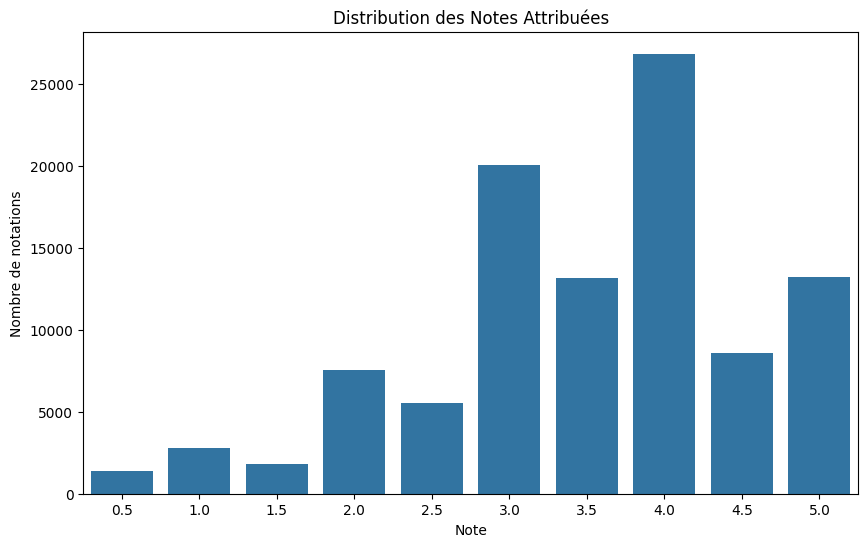

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribution des Notes Attribuées')
plt.xlabel('Note')
plt.ylabel('Nombre de notations')
plt.show()

C:\Users\Yoga\AppData\Local\Temp\ipykernel_1060\3256705447.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')


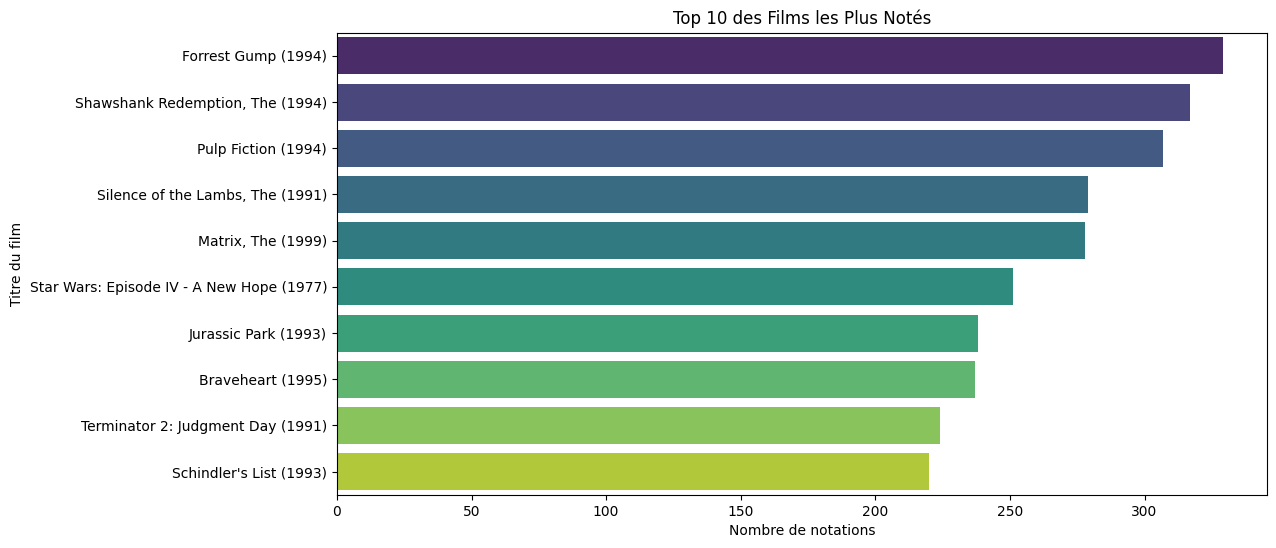

In [8]:
top_movies = df['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')
plt.title('Top 10 des Films les Plus Notés')
plt.xlabel('Nombre de notations')
plt.ylabel('Titre du film')
plt.show()

C:\Users\Yoga\AppData\Local\Temp\ipykernel_1060\3935912188.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y=movie_stats.index, data=movie_stats, palette='magma')


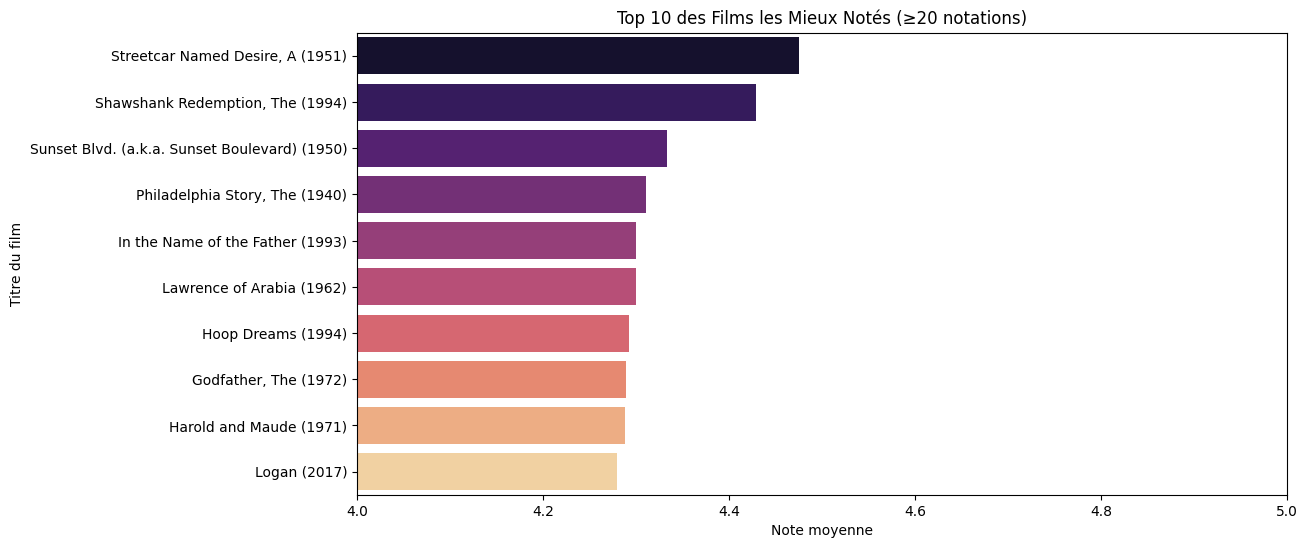

In [9]:
movie_stats = df.groupby('title').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).query('num_ratings >= 20').sort_values('avg_rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y=movie_stats.index, data=movie_stats, palette='magma')
plt.title('Top 10 des Films les Mieux Notés (≥20 notations)')
plt.xlabel('Note moyenne')
plt.ylabel('Titre du film')
plt.xlim(4, 5)
plt.show()

#### Re-indexing


**=> userId for Q-Table rows** 

**=> movieId for Q-Table columns** 

**=> idx_to_movie when argmax(Q[“state”]) is extracted to translate the index into a real movieId**.

In [10]:
user_to_idx = {uid: idx for idx, uid in enumerate(sorted(df['userId'].unique()))}
movie_to_idx = {mid: idx for idx, mid in enumerate(sorted(df['movieId'].unique()))}
idx_to_movie = {idx: mid for mid, idx in movie_to_idx.items()}
idx_to_title = dict(zip(df['movieId'], df['title']))
movie_genres = dict(zip(df['movieId'], df['genres']))

In [11]:
n_users = len(user_to_idx)
n_movies = len(movie_to_idx)

#### Extract all possible movie genres


In [12]:
genre_set = set()
for g in df['genres']:
    if isinstance(g, str):
        genre_set.update(g.split('|'))
        
all_genres = sorted(genre_set)
genre_to_idx = {g: i for i, g in enumerate(all_genres)}

#### Genre coding for each film

In [13]:
def encoder_genres(genre_str):
    vector = np.zeros(len(all_genres))
    for g in genre_str.split('|'):
        if g in genre_to_idx:
            vector[genre_to_idx[g]] = 1
    return vector

In [ ]:
movie_genre_vectors = {
    mid: encoder_genres(genre_str) 
    if isinstance(genre_str, str) 
    else np.zeros(len(all_genres)) 
    for mid, genre_str in movie_genres.items()
    }


#### Q-table


In [ ]:
q_table = np.zeros((n_users, n_movies))

# Hyperparamètres
alpha,gamma,epsilon,episodes ,max_steps,coeff_genre = 0.1, 0.9, 0.1,500, 10, 0.5


#### Politique ε-greedy


In [ ]:
def choisir_action(user_idx):
    if np.random.rand() < epsilon:
        movie_idx = np.random.randint(n_movies)
    else:
        q_values = q_table[user_idx]
        movie_idx = np.argmax(q_values)
    return movie_idx

#### Get a user's favorite genres



In [ ]:

def genres_utilisateur(user_id):
    liked = df[(df['userId'] == user_id) & (df['rating'] >= 3.0)]
    if liked.empty:
        return np.zeros(len(all_genres))
    vectors = np.array(
        [movie_genre_vectors[mid] 
         for mid in liked['movieId'] 
         if mid in movie_genre_vectors]
         )
    return vectors.mean(axis=0)

#### genre affinity awards




coeff_genre (poids de la similarité de genres)

La formule utilisée ici ressemble à un cosine similarity partiel (cosinus de l’angle entre deux vecteurs), mais on normalise uniquement le vecteur de l’utilisateur :

similarity= 𝑢⋅𝑣 / ∥𝑢∥+𝜀
​


In [18]:
def obtenir_recompense(user_idx, movie_idx):
    user_id = list(user_to_idx.keys())[user_idx]
    movie_id = list(movie_to_idx.keys())[movie_idx]

    note_row = df[(df['userId'] == user_id) & (df['movieId'] == movie_id)]
    note_reward = 1 if not note_row.empty and note_row['rating'].values[0] >= 3.0 else 0

    user_pref = genres_utilisateur(user_id)
    movie_vec = movie_genre_vectors.get(movie_id, np.zeros(len(all_genres)))
    genre_similarity = np.dot(user_pref, movie_vec) / (np.linalg.norm(user_pref) + 1e-5)

    return note_reward + coeff_genre * genre_similarity

#### SARSA training



In [ ]:
clics_par_episode = []

for ep in tqdm(range(episodes), desc="Training"):
    for user_idx in range(n_users):
        user_id = list(user_to_idx.keys())[user_idx]
        movie_idx = choisir_action(user_idx)
        for step in range(max_steps):
            next_movie_idx = choisir_action(user_idx)
            
            r = obtenir_recompense(user_idx, movie_idx)
            q_current = q_table[user_idx, movie_idx]
            q_next = q_table[user_idx, next_movie_idx]

            q_table[user_idx, movie_idx] += alpha * (r + gamma * q_next - q_current)

            movie_idx = next_movie_idx
            total_reward += r

    clics_par_episode.append(total_reward)

Training SARSA: 100%|██████████| 500/500 [3:06:07<00:00, 22.34s/it]  


#### Plot training curve


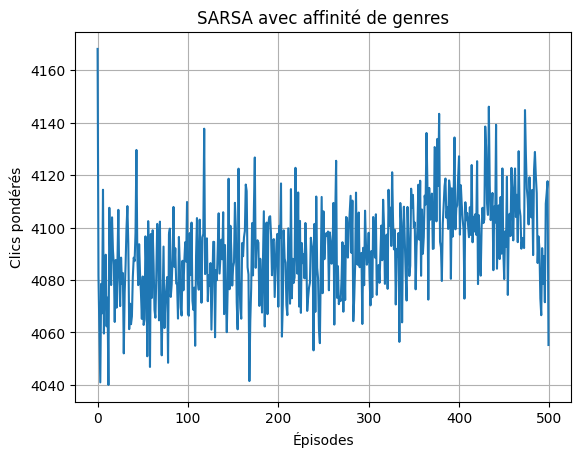

In [45]:
plt.plot(clics_par_episode)
plt.title("SARSA avec affinité de genres")
plt.xlabel("Épisodes")
plt.ylabel("Clics pondérés")
plt.grid()
plt.show()


### 📈 Ce que montre la courbe
    Fluctuations importantes au début :

L’algorithme explore encore beaucoup, donc les actions prises sont assez aléatoires.

Les valeurs Q sont encore peu précises.

    Tendance légèrement ascendante jusqu’à ~400 épisodes :

Le modèle commence à mieux exploiter ce qu’il a appris.

Il propose plus souvent des films correspondant aux genres préférés.

    Stabilisation/variation ensuite :

Il n’y a pas de hausse spectaculaire, mais le modèle reste performant.

Cela peut indiquer que le modèle a atteint un plateau d’apprentissage

#### Recommend N unseen movies to a user


In [48]:
def recommend_movies_for_user(user_id, N=5):
    user_idx = user_to_idx[user_id]
    seen_movies = set(df[df['userId'] == user_id]['movieId'])
    unseen_movie_indices = [idx for idx in range(n_movies) if idx_to_movie[idx] not in seen_movies]
    q_values = [(idx, q_table[user_idx, idx]) for idx in unseen_movie_indices]
    top_q = sorted(q_values, key=lambda x: x[1], reverse=True)[:N]
    return [(idx_to_movie[idx], idx_to_title[idx_to_movie[idx]], q) for idx, q in top_q]


#### Generate recommendations for all users and save to CSV


In [49]:
recommendations = []

for user_id in tqdm(user_to_idx.keys(), desc="Generating recommendations"):
    recs = recommend_movies_for_user(user_id, N=5)
    for movie_id, title, score in recs:
        recommendations.append({
            'userId': user_id,
            'movieId': movie_id,
            'title': title,
            'Q_value': round(score, 4)
        })

Generating recommendations: 100%|██████████| 610/610 [00:07<00:00, 76.57it/s] 


In [ ]:
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv("data/recommendations_sarsa.csv", index=False)
print("✅ Recommendations saved to data/recommendations_sarsa.csv")

✅ Recommendations saved to data/recommendations_sarsa.csv


In [51]:
df_reco1 = pd.read_csv("data/recommendations_sarsa.csv")

In [52]:
df_reco1.head(10)

,userId,movieId,title,Q_value
0,1,170937,Win It All (2017),1.1940
1,1,5581,Betsy's Wedding (1990),0.2577
2,1,59727,"Strangers, The (2008)",0.2424
3,1,169982,Power Rangers (2017),0.2347
4,1,184257,Making a Murderer (2015),0.2188
5,2,1,Toy Story (1995),1.0337
6,2,3394,Blind Date (1987),0.2607
7,2,64983,Valkyrie (2008),0.2555
8,2,90249,Real Steel (2011),0.2358
9,2,3011,"They Shoot Horses, Don't They? (1969)",0.2354
